In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
Ls = [20, 50, 100, 200]
# bs = [1.651, 1.675, 1.701, 1.725, 1.749, 1.751, 1.775, 1.799, 1.801, 1.825, 1.851]
bs = [1.651, 1.675, 1.701, 1.725, 1.751, 1.775, 1.801, 1.825, 1.851]
Nfields = 40
DROP = 1000
CALC = 1500
EVERY = 1

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 456, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [6]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [4]:
%load_ext cython

In [5]:
%%cython
import numpy as np
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve(long[:, :] field, double b, long num_epoch=1):
    cdef:
        int L = field.shape[0]
        int x, y, x1, x2, x3, y1, y2, y3, i, j, bestX, bestY
        double N = field.shape[0]
        long[:, :] next_state = np.zeros((L, L), dtype=int)
        double[:, :] scores = np.zeros((L, L), dtype=float)
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        double f_c
        
    assert L != 0
    
    next_state = field.copy()
    
    for _ in range(num_epoch):
        f_c = np.sum(field)/(N*N)
        scores[...] = _zeros
        for x in range(L):
            for y in range(L):
                x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
                y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
#                 return ((x1, x2, x3), (y1, y2, y3))
                scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                field[x2, y1] + f_c + field[x2, y3] +
                                field[x3, y1] + field[x3, y2] + field[x3, y3])
                if field[x, y] == 0:
                    scores[x, y] *= b
#         return scores
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if scores[(x+i)%L, (y+j)%L] > scores[bestX, bestY]:
                            bestX = (x+i)%L
                            bestY = (y+j)%L

                next_state[x, y] = field[bestX, bestY]
        
        field = next_state.copy()
        
    return np.asarray(field)

In [9]:
field = np.load("fields/field_20_10.npy")
d = []
for _ in tqdm(range(int(200)), total=int(200)):
    field = evolve(field, 1.3, 1)
#             print(field.sum()/(1.*50^2))
    d.append(field.sum()/(1.*field.shape[0]**2))

100%|██████████| 200/200 [00:00<00:00, 2022.05it/s]


<IPython.core.display.Javascript object>


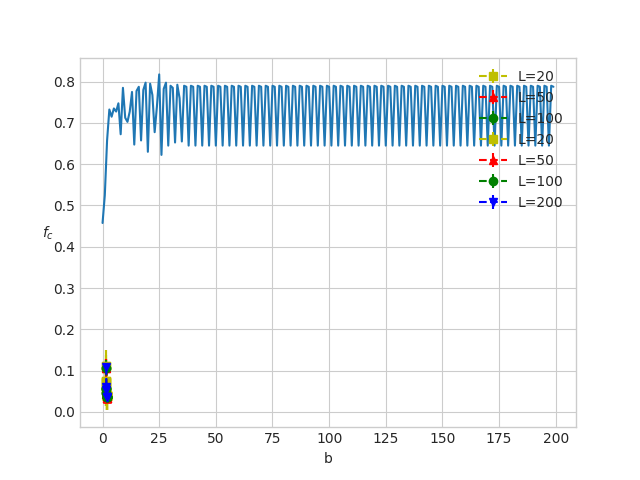

In [10]:
plt.plot(d)

In [11]:
density = []
for L in Ls[:-1]:
    den = []
    for b in tqdm(bs):
        d = []
        for i in range(len(seeds)):
            field = np.load("fields/field_{}_{}.npy".format(L, i) )
            field = evolve(field, b, DROP)
            for _ in range(0, CALC-DROP, EVERY):
                field = evolve(field, b, EVERY)
                d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

100%|██████████| 9/9 [1:52:24<00:00, 780.16s/it]


In [12]:
density2 = []
for L in [200]:
    den = []
    for b in [1.650, 1.675, 1.701, 1.751, 1.801, 1.851]:
        d = []
        for i in tqdm(range(len(seeds[:25])), total=len(seeds[:25])):
            field = np.load("fields/field_{}_{}.npy".format(L, i) )
            field = evolve(field, b, DROP)
            for _ in range(0, CALC-DROP, EVERY):
                field = evolve(field, b, EVERY)
                d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density2.append(den)

100%|██████████| 25/25 [32:34<00:00, 77.85s/it]


In [13]:
np.save("density_evol_new.npy", np.asarray(density))
np.save("density_evol_200_new.npy", np.asarray(density2))

In [14]:
density = np.load("density_evol_new.npy")
density2 = np.load("density_evol_200_new.npy")

In [15]:
std = density.std(axis=2)
std2 = density2.std(axis=2)

In [16]:
means = density.mean(axis=2)
means2 = density2.mean(axis=2)

In [30]:
density2.shape

(1, 6, 2375)

<IPython.core.display.Javascript object>


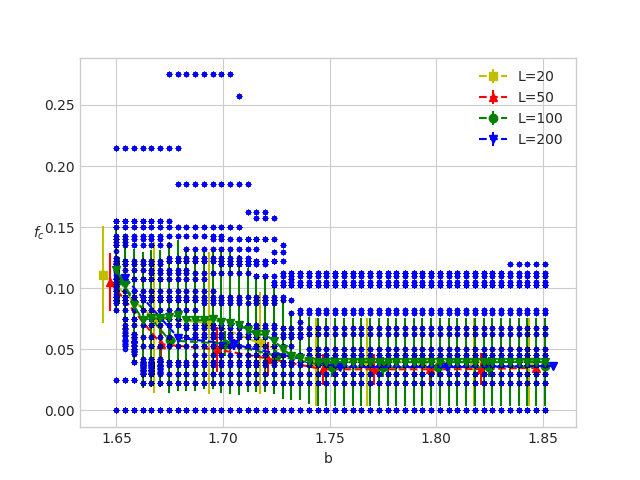

Text(0, 0.5, '$f_c$')

In [43]:
plt.errorbar(np.array(bs)-.0075, means[0], yerr=std[0], fmt="sy--", label="L=20")
plt.errorbar(np.array(bs)-.004, means[1], yerr=std[1], fmt="^r--", label="L=50")
plt.errorbar(np.array(bs), means[2], yerr=std[2], fmt="og--", label="L=100")
plt.errorbar(np.array([1.650, 1.675, 1.701, 1.751, 1.801, 1.851])+0.004, means2[0], yerr=std2[0], fmt="vb--", label="L=200")
# plt.errorbar([1.7], [np.asarray(dex).mean()], fmt=">y", label="L=500")
plt.legend(loc="upper right")
plt.xlabel("b")
# plt.yticks(np.arange(0., 1.1, .1))
plt.ylabel("$f_c$", rotation=0)
# plt.errorbar([1.650, 1.675, 1.749, 1.751, 1.799, 1.801, 1.851], means2[0], yerr=std2[0], fmt="vb--", label="L=200")
# plt.errorbar([1.7], [np.asarray(dex).mean()], fmt=">y", label="L=500")

In [ ]:
ву

<IPython.core.display.Javascript object>


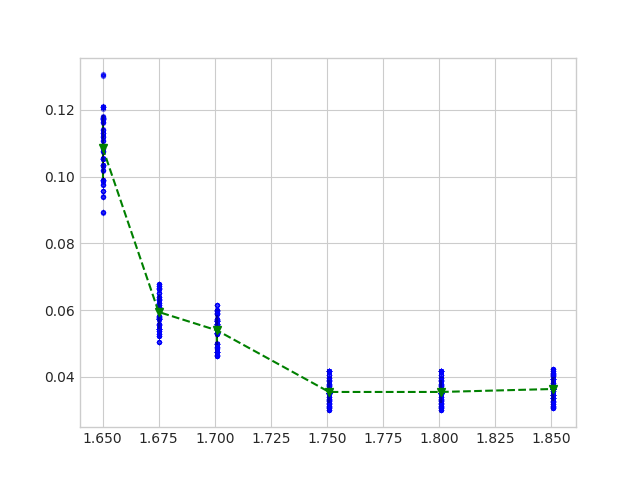

<ErrorbarContainer object of 3 artists>

In [42]:
for i, b in enumerate([1.650, 1.675, 1.701, 1.751, 1.801, 1.851]):
    plt.errorbar([b], density2[0][i], fmt=".b", alpha=0.01)

plt.errorbar(np.array([1.650, 1.675, 1.701, 1.751, 1.801, 1.851]), means2[0], yerr=std2[0], fmt="vg--", label="L=200")

In [6]:
density = []
for L in Ls[2:3]:
    den = []
    for b in tqdm(np.linspace(.9, 3, 60)):
        d = []
        for i in range(len(seeds)):
            field = np.load("fields/field_{}_{}.npy".format(L, i) )
            field = evolve(field, b, DROP)
            for _ in range(0, CALC-DROP, EVERY):
                field = evolve(field, b, EVERY)
                d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

100%|██████████| 60/60 [2:23:38<00:00, 322.85s/it]


In [8]:
density = np.array(density)

In [9]:
density.shape

(1, 60, 20000)

<IPython.core.display.Javascript object>


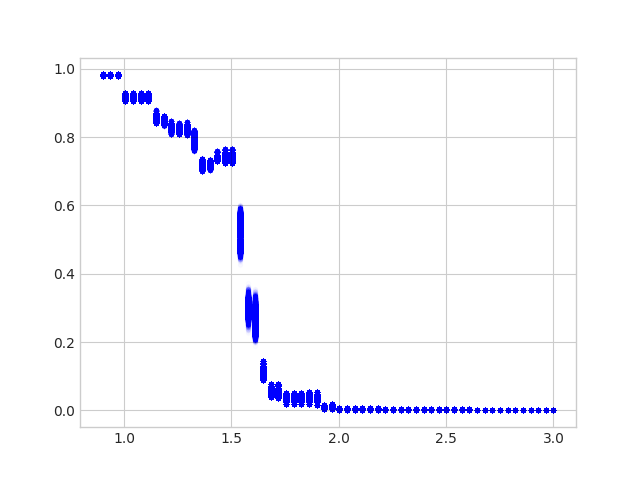

In [18]:
for i, b in enumerate(np.linspace(.9, 3, 60)):
    plt.errorbar([b]*20000, density[:, i].flat, fmt=".b", alpha=1/100)

In [19]:
density[0, 50:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
std = np.array(density).std(axis=2)
means = np.array(density).mean(axis=2) 

In [ ]:
# for i, b in enumerate(np.linspace(1.650, 1.851, 50)):
#     plt.errorbar([b], density[0][i], fmt=".b", alpha=0.01)

plt.errorbar(np.linspace(1.650, 1.851, 50), means[0], yerr=std[0], fmt="vg--", label="L=200")